In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, scipy
import scipy.sparse as sp
import warnings
import anndata
warnings.filterwarnings("ignore")

# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri
#import numpy2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [ ]:
adata_concat = sc.read('Data/adata_concat.h5ad')
adata_D25 = adata_concat[adata_concat.obs['day'].isin(['D25'])]

# Integration and annotation

In [3]:
%%R -i adata_D25 -o adata_integrated -o umap_emb -o pca_emb -o hvg_list

Csparse_validate = "CsparseMatrix_validate"
library(Seurat)
library(dplyr)

sobj <- as.Seurat(adata_D25, counts = "counts", data = NULL)

sobj_list <- SplitObject(sobj, split.by = 'reactionID')

sobj_list <- lapply(X = sobj_list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

features <- SelectIntegrationFeatures(object.list = sobj_list,nfeatures = 2000)

sobj_list <- lapply(X = sobj_list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, features = features, verbose = FALSE)
  })

anchors <- FindIntegrationAnchors(object.list = sobj_list, anchor.features = features, reduction = "rpca")
sobj <- IntegrateData(anchorset = anchors,k.weight=80)
DefaultAssay(sobj) <- "integrated"
sobj <- ScaleData(sobj) %>% RunPCA(.)
sobj <- RunUMAP(sobj, dims = 1:40)
sobj <- FindNeighbors(sobj, dims = 1:40)
sobj <- FindClusters(sobj,resolution=0.85)
sobj <- FindClusters(sobj,resolution=1)
sobj <- FindClusters(sobj,resolution=1.2)

pca_emb = Embeddings(object = sobj, reduction = "pca")
hvg_list = rownames(sobj)

DefaultAssay(sobj) <- "originalexp"

umap_emb = Embeddings(object = sobj, reduction = "umap")
adata_integrated = as.SingleCellExperiment(sobj) 

saveRDS(sobj,'Data/d25_seurat.rds')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
     |                                                  | 0 % ~calculating   |+++++++++++++++++                                 | 33% ~01s           |++++++++++++++++++++++++++++++++++                | 67% ~00s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=01s  
  |                                                  | 0 % ~calculating   |+++++++++++++++++                                 | 33% ~02s           |++++++++++++++++++++++++++++++++++                | 67% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=02s  
  |                                                  | 0 % ~calculating   |+++++++++++++++++                                 | 33% ~07s           |++++++++++++++++++++++++++++++++++                | 67% ~03s           |++++++++

Attaching SeuratObject

Attaching package: ‘Seurat’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays


Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union

The following object is masked from ‘package:GenomeInfoDb’:

    intersect

The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union

The following object is masked from ‘package:matrixStats’:

    count

The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Performing log-normalizati

In [6]:
adata_D25.obsm['X_umap'] = umap_emb
adata_D25.obsm['X_pca'] = umap_emb
adata_D25.var['highly_variable'] = adata_D25.var.index.isin(hvg_list)

adata_D25.obs['integrated_snn_res.0.85'] = adata_integrated.obs['integrated_snn_res.0.85']

adata_D25.obs['integrated_snn_res.1'] = adata_integrated.obs['integrated_snn_res.1']
adata_D25.obs['integrated_snn_res.1.2'] = adata_integrated.obs['integrated_snn_res.1.2']





#with plt.rc_context({ "figure.dpi": 250, "figure.figsize": (4,4)}):
with plt.rc_context({ "figure.dpi": 250}):
    sc.pl.umap(adata_D25, color=['integrated_snn_res.0.5','integrated_snn_res.0.55','integrated_snn_res.0.6',
                                'integrated_snn_res.0.65','integrated_snn_res.0.7','integrated_snn_res.0.75',
                                'integrated_snn_res.0.8','integrated_snn_res.0.85'],legend_loc='on data',
    use_raw=False, size=10,frameon=False,  ncols=2,cmap='jet', colorbar_loc=None,wspace=-0.05)

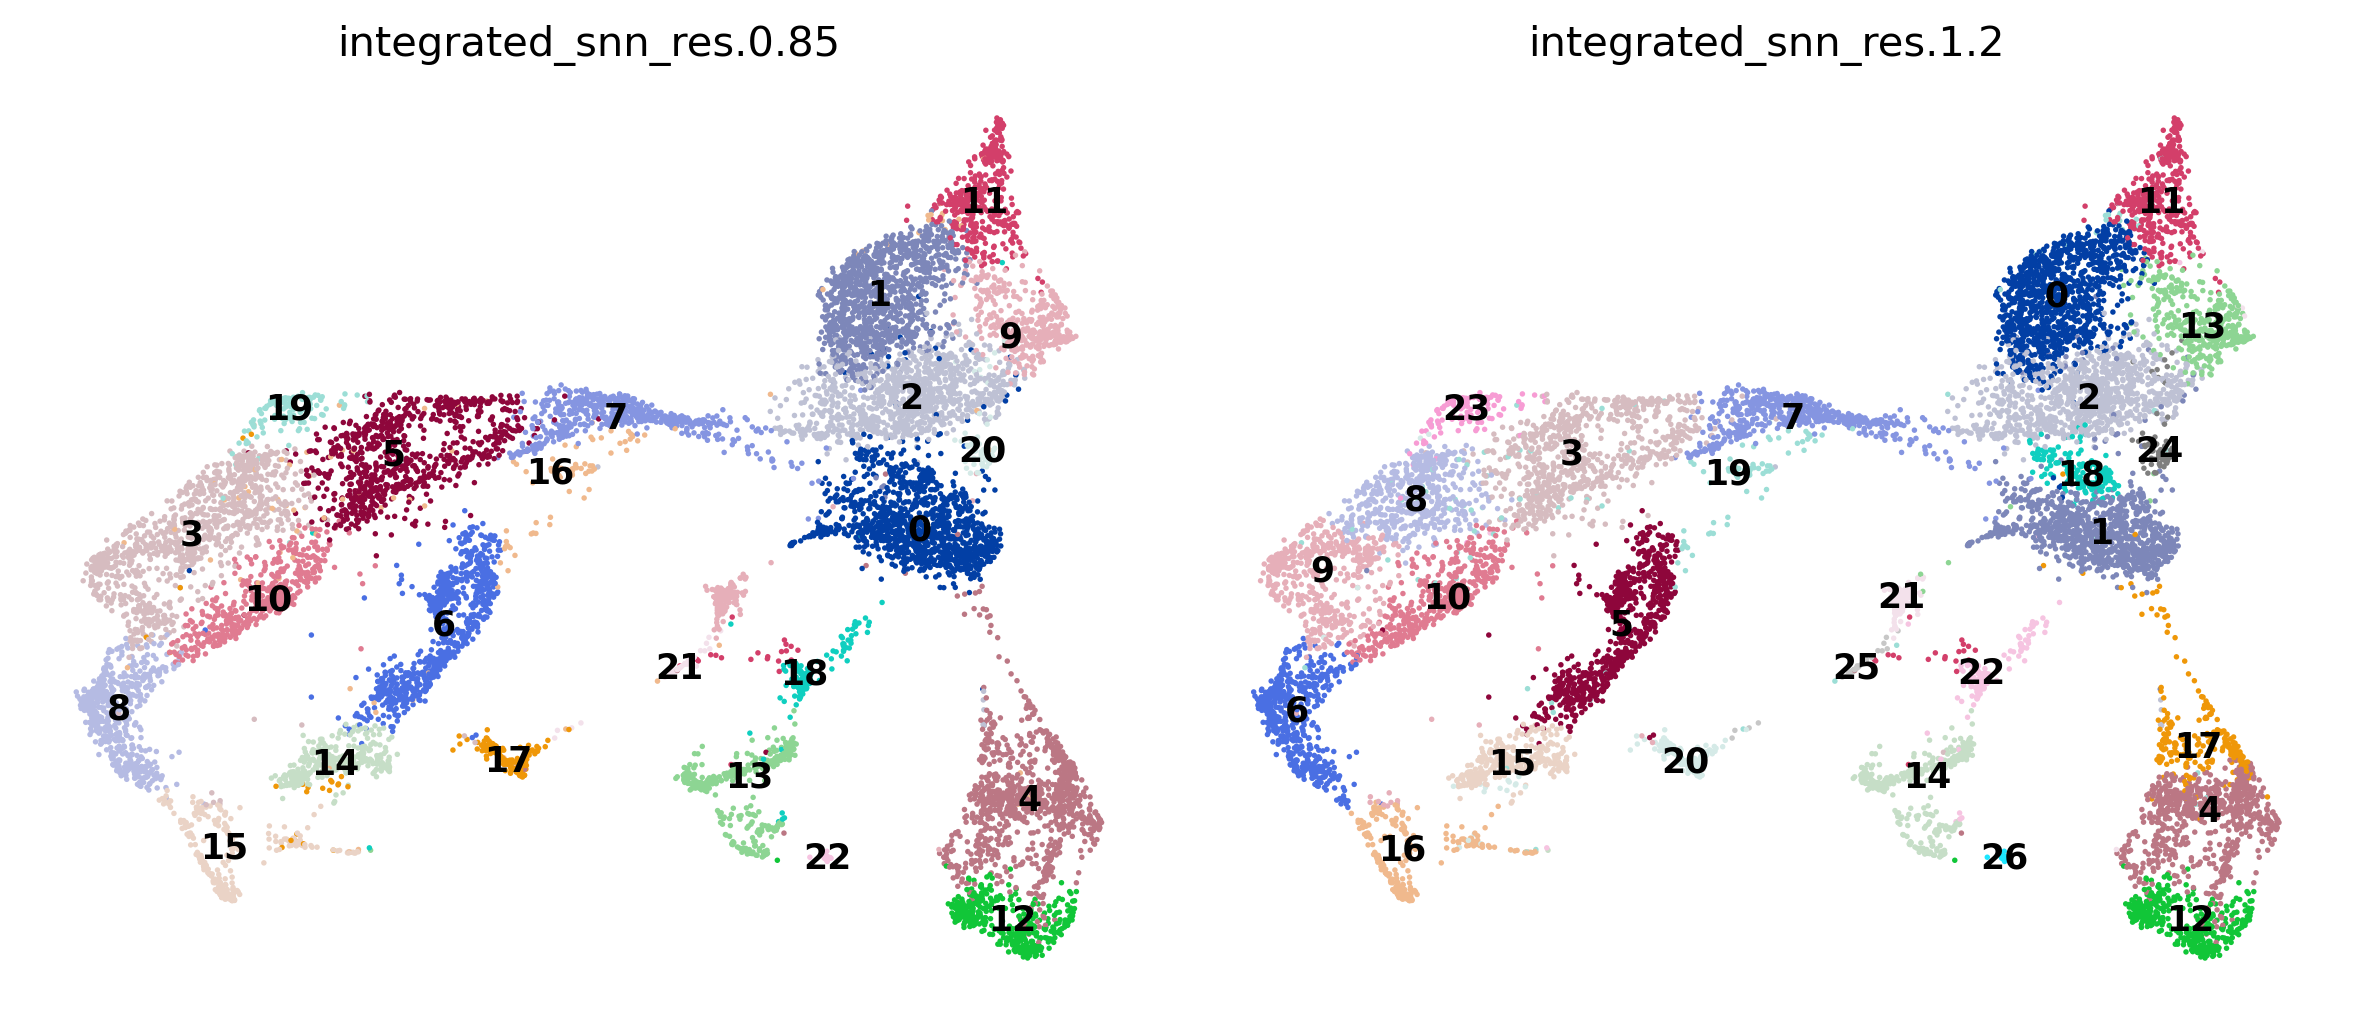

In [8]:
#with plt.rc_context({ "figure.dpi": 250, "figure.figsize": (4,4)}):
with plt.rc_context({ "figure.dpi": 250}):
    sc.pl.umap(adata_D25, color=['integrated_snn_res.0.85','integrated_snn_res.1.2'],legend_loc='on data',
    use_raw=False, size=10,frameon=False,  ncols=2,cmap='jet', colorbar_loc=None,wspace=-0.05)

In [6]:
adata_D25.obs['Cell_types'] = 'Unassigned'

pomc = pd.Series(list(adata_D25[adata_D25.obs["integrated_snn_res.0.85"].isin(['3'])].obs.index), dtype="category")
adata_D25.obs["Cell_types"].loc[pomc] = "POMC+ neurons"

dlx = pd.Series(list(adata_D25[adata_D25.obs["integrated_snn_res.0.85"].isin(['6','14'])].obs.index), dtype="category")
adata_D25.obs["Cell_types"].loc[dlx] = "DLX6-AS1+ neurons"

otp = pd.Series(list(adata_D25[adata_D25.obs["integrated_snn_res.0.85"].isin(['10','8'])].obs.index), dtype="category")
adata_D25.obs["Cell_types"].loc[otp] = "OTP+ neurons"

nr5a2 = pd.Series(list(adata_D25[adata_D25.obs["integrated_snn_res.0.85"].isin(['15'])].obs.index), dtype="category")
adata_D25.obs["Cell_types"].loc[nr5a2] = "NR5A2/ONECUT1/3+ neurons"

tele = pd.Series(list(adata_D25[adata_D25.obs["integrated_snn_res.0.85"].isin(['17','21'])].obs.index), dtype="category")
adata_D25.obs["Cell_types"].loc[tele] = "Telencephalic neurons"

arc_imm = pd.Series(list(adata_D25[adata_D25.obs["integrated_snn_res.0.85"].isin(['7','5','19','16'])].obs.index), dtype="category")
adata_D25.obs["Cell_types"].loc[arc_imm] = "ARC precursors"

optic = pd.Series(list(adata_D25[adata_D25.obs["integrated_snn_res.0.85"].isin(['18','13','22'])].obs.index), dtype="category")
adata_D25.obs["Cell_types"].loc[optic] = "Optic area progenitors"

tany = pd.Series(list(adata_D25[adata_D25.obs["integrated_snn_res.0.85"].isin(['12','4','1','0', '9','2','11','20'])].obs.index), dtype="category")
adata_D25.obs["Cell_types"].loc[tany] = "Tanycytes"

vlmc = pd.Series(list(adata_D25[adata_D25.obs['integrated_snn_res.1.2'].isin(['21'])].obs.index), dtype="category")
adata_D25.obs["Cell_types"].loc[vlmc] = "Unassigned"

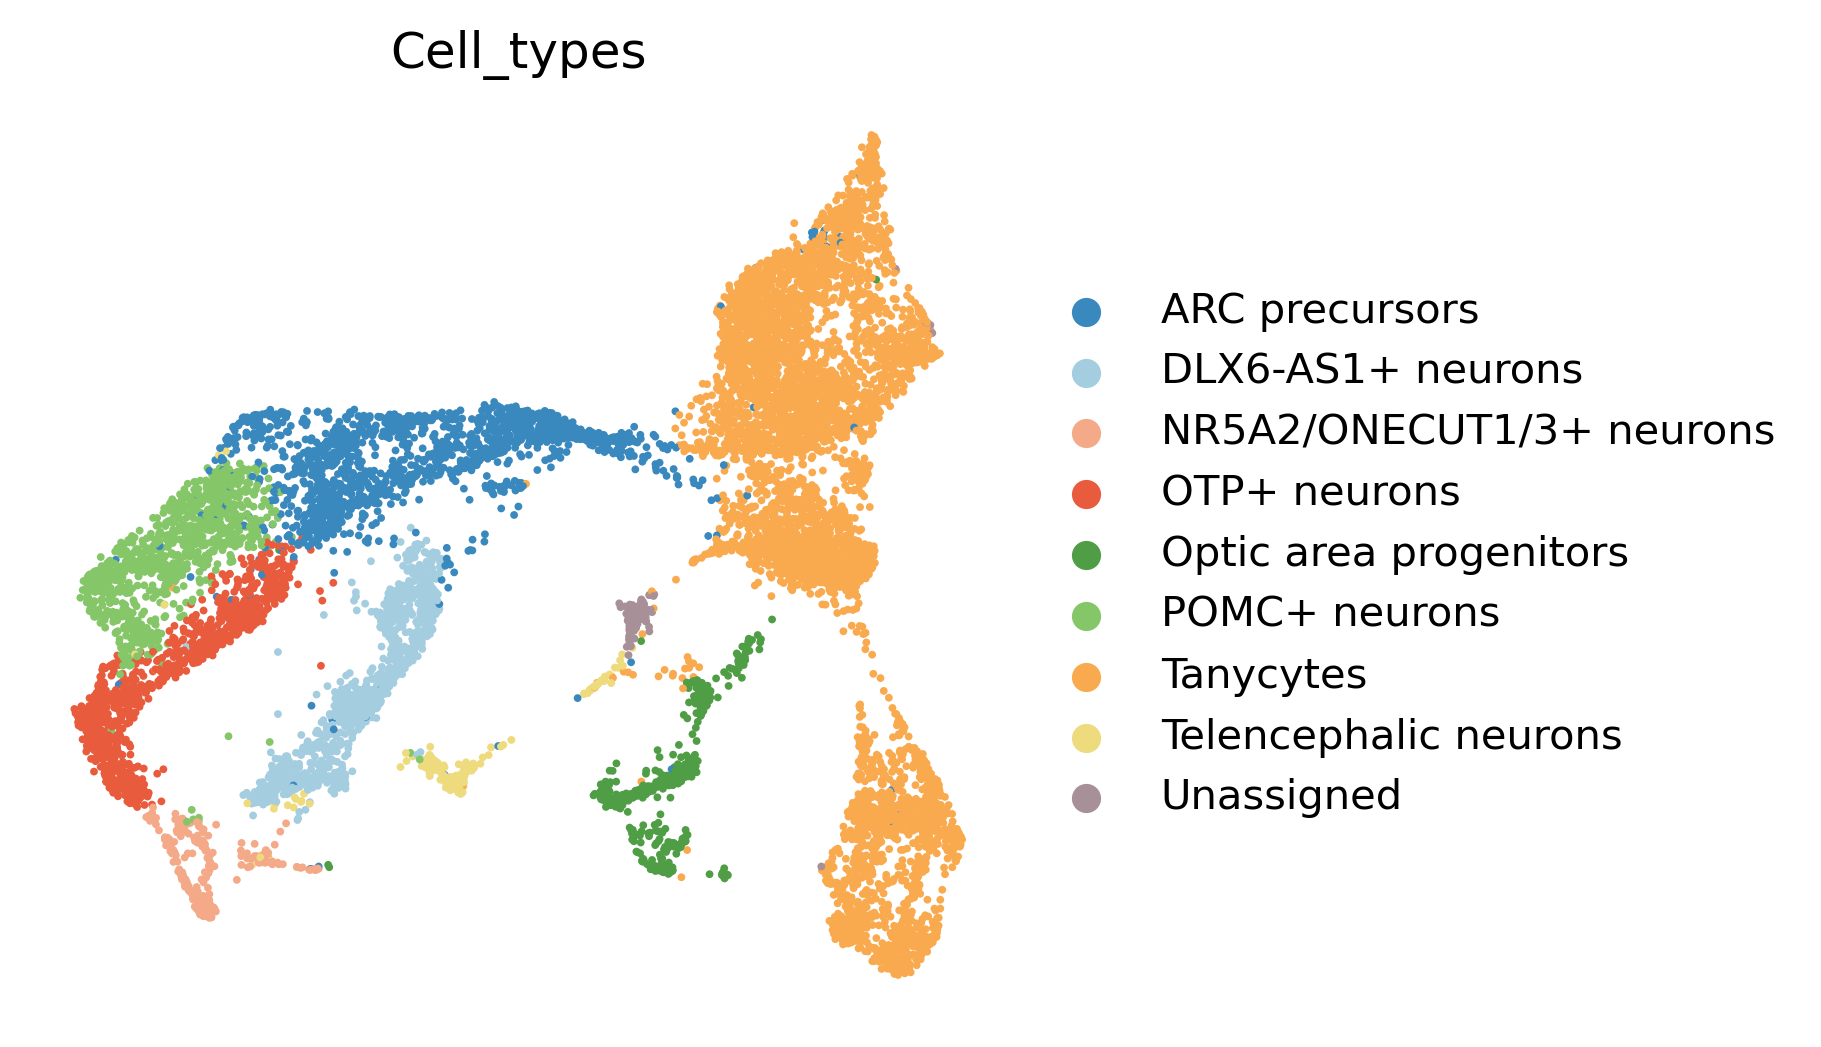

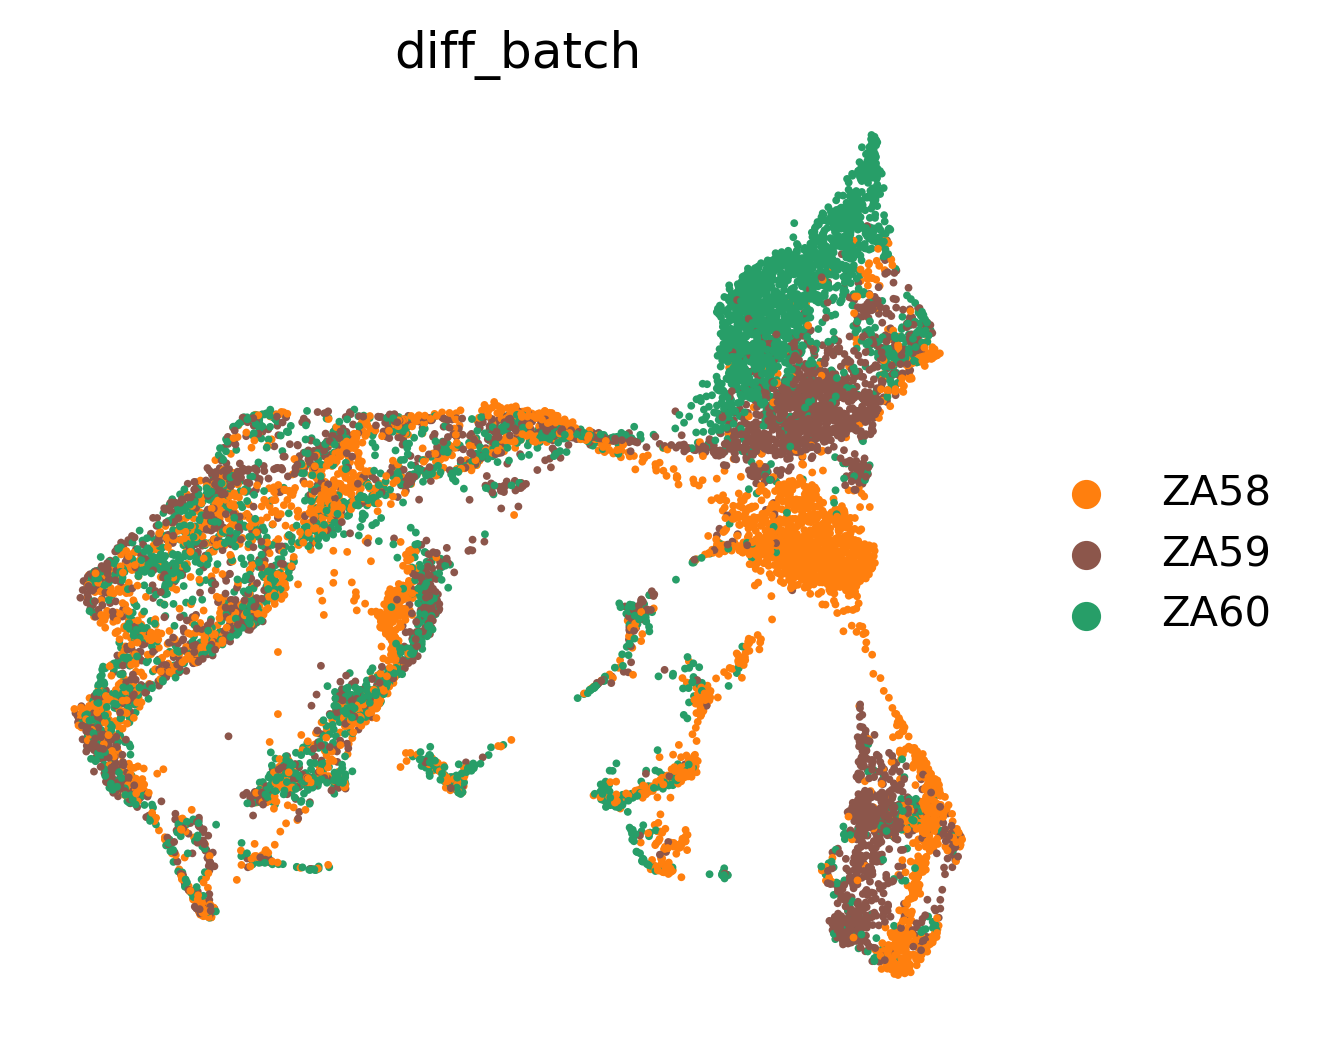

In [9]:
palette_cell_types = ['#3A89BE','#A4CDE0','#f4a989','#e85b3d','#4F9E46','#85C668','#FAAA4E','#EDDB7E','#a79098']
with plt.rc_context({ "figure.dpi": 300, "figure.figsize": (4.2,4) }):
    sc.pl.umap(adata_D25, color=['Cell_types'],palette=palette_cell_types, ncols=2, use_raw=False, cmap='jet', frameon=False, colorbar_loc=None,size=14)
    
palette_batch=['#ff7f0eff', '#8c564bff', '#279e68ff']
with plt.rc_context({ "figure.dpi": 300, "figure.figsize": (4.2,4) }):
    sc.pl.umap(adata_D25, color=['diff_batch'],palette=palette_batch, ncols=2, use_raw=False, cmap='jet', frameon=False, colorbar_loc=None,size=14)


In [12]:
adata_D25.write('Data/adata_d25_annotated.h5ad')

# Dotplot

In [6]:
adata_D25 = sc.read('Data/adata_d25_annotated.h5ad')

In [7]:
%%R -i adata_D25
library(Seurat)

sobj <- as.Seurat(adata_D25, counts = NULL, data = "log_transformed")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Attaching SeuratObject

Attaching package: ‘Seurat’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays



In [9]:
%%R
library(ggplot2)
genes = c('TBX3','SOX2','STMN2','ISL1','DLX6-AS1','NR5A2','ONECUT1','NR2F1','CRABP1','OTP','POMC','PRDM12','RAX','NFIA','DIO2','FOXG1','VLMC')
Idents(object = sobj) <- "Cell_types"
Idents(object = sobj) <- factor(sobj@active.ident, sort(levels(sobj@active.ident),decreasing=T)) 

#dotplot=DotPlot(object = sobj, features = genes, scale=T,dot.min='0.1') + theme(axis.text.x = element_text(angle = 45, hjust=1))
dotplot=DotPlot(object = sobj, features = genes, scale=T,dot.min='0.1',  cols = c("#FFFFFF", "#386fa4")) + theme(axis.text.x = element_text(size=10, face="italic", angle = 45, hjust=1), axis.text.y = element_text(size=10), legend.title = element_text(size=8)) + ylab("")

ggsave("figures/d25_dotplot.pdf", plot= dotplot, width=7.5, height=3.45, dpi=300, bg='white')

In addition: Warning messages:
1: In FetchData.Seurat(object = object, vars = features, cells = cells) :
  The following requested variables were not found: VLMC
2: Removed 81 rows containing missing values or values outside the scale range
(`geom_point()`). 


# Featureplots

In [2]:
adata = sc.read('Data/adata_d25_annotated.h5ad')

In [3]:
#RAX, TBX3 and NKX2-1
for color in ['CRYM']:
    with plt.rc_context({ "figure.dpi": 300, "figure.figsize": (4.2,4) }):
        sc.pl.umap(adata, color=color, ncols=2, use_raw=False, cmap='jet', frameon=False, colorbar_loc=None,size=18, save=f'd25_{color}.pdf', show=False,layer='log_transformed')
        #sc.pl.umap(adata, color=color, ncols=2, use_raw=False, cmap='jet', frameon=False, colorbar_loc=None,size=18)

# DGE list

In [24]:
adata = sc.read('Data/adata_d25_annotated.h5ad')

In [6]:
%%R -i adata

Csparse_validate = "CsparseMatrix_validate"
library(Seurat)
library(edgeR)

seur <- as.Seurat(adata, counts = "counts", data = NULL)

#seur <- readRDS("Data/d50_d70_neurons_seurat.rds")
seur <- RenameAssays(seur, originalexp="RNA")

y <- Seurat2PB(seur, sample = "diff_batch_2", cluster = "Cell_types")
keep.samples <- y$samples$lib.size > 5e4
y <- y[, keep.samples]
keep.genes <- filterByExpr(y, group=y$samples$cluster)
y <- y[keep.genes, , keep=FALSE]
y <- normLibSizes(y)

cluster <- as.factor(y$samples$cluster)
#plotMDS(y, pch=16, col=c(2:16)[cluster], main="MDS")
#legend("bottomright", legend=paste0("cluster",levels(cluster)), pch=16, col=2:16, cex=0.8)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Attaching SeuratObject

Attaching package: ‘Seurat’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays

Loading required package: limma

Attaching package: ‘limma’

The following object is masked from ‘package:BiocGenerics’:

    plotMA


Attaching package: ‘edgeR’

The following object is masked from ‘package:SingleCellExperiment’:

    cpm

Renaming default assay from originalexp to RNA
In addition: Warning message:
Cannot add objects with duplicate keys (offending key: originalexp_) setting key to original value 'rna_' 


In [7]:
%%R
batch <- factor(y$samples$sample)
design <- model.matrix(~ cluster + batch)
colnames(design) <- gsub("batch", "", colnames(design))
colnames(design)[1] <- "Int"
head(design)

  Int clusterDLX6-AS1+ neurons clusterNR5A2/ONECUT1/3+ neurons
1   1                        0                               0
2   1                        1                               0
3   1                        0                               1
4   1                        0                               0
5   1                        0                               0
6   1                        0                               0
  clusterOptic area progenitors clusterOTP+ neurons clusterPOMC+ neurons
1                             0                   0                    0
2                             0                   0                    0
3                             0                   0                    0
4                             1                   0                    0
5                             0                   1                    0
6                             0                   0                    1
  clusterTanycytes clusterTelencephalic neurons 

In [8]:

%%R
y <- estimateDisp(y, design, robust=TRUE)
fit <- glmQLFit(y, design, robust=TRUE)


In [9]:
%%R
ncls <- nlevels(cluster)
contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
diag(contr) <- 1
contr[1,] <- 0
rownames(contr) <- colnames(design)
colnames(contr) <- paste0("cluster", levels(cluster))
contr

                                clusterARC precursors clusterDLX6-AS1+ neurons
Int                                             0.000                    0.000
clusterDLX6-AS1+ neurons                       -0.125                    1.000
clusterNR5A2/ONECUT1/3+ neurons                -0.125                   -0.125
clusterOptic area progenitors                  -0.125                   -0.125
clusterOTP+ neurons                            -0.125                   -0.125
clusterPOMC+ neurons                           -0.125                   -0.125
clusterTanycytes                               -0.125                   -0.125
clusterTelencephalic neurons                   -0.125                   -0.125
clusterUnassigned                              -0.125                   -0.125
-2                                              0.000                    0.000
-3                                              0.000                    0.000
                                clusterNR5A2/ONECUT1

In [10]:
%%R
qlf <- list()
for(i in 1:ncls){
 qlf[[i]] <- glmQLFTest(fit, contrast=contr[,i])
 qlf[[i]]$comparison <- paste0("cluster", levels(cluster)[i], "_vs_others")
}

In [11]:
%%R
top <- 200
topMarkers <- list()

de_df = data.frame(matrix( 
  vector(), 0, 7, dimnames=list(c(), c("gene","logFC","logCPM","F","PValue","FDR",'comparison'))), 
                stringsAsFactors=F)

for(i in 1:ncls) {
    #print(head(qlf[[i]])$comparison)
    ord <- order(qlf[[i]]$table$PValue, decreasing=FALSE)
    up <- qlf[[i]]$table$logFC[ord] > 0
    topMarkers[[i]] <- rownames(y)[ord[up][1:top]]
    #genes = 
    df = as.data.frame(topTags(qlf[[i]], n='all'))
    df =df[rownames(df) %in% rownames(y)[ord[up][1:top]], ]  
    df$comparison <- head(qlf[[i]])$comparison
    de_df = rbind(de_df, df)
}
print(dim(de_df))

write.csv(de_df, "d25_arc_de_list.csv")
#topMarkers <- unique(unlist(topMarkers))
#topMarkers

[1] 1800    8


In [12]:
de_genes = pd.read_csv('d25_arc_de_list.csv',index_col=0)
de_genes['cluster'] = de_genes['comparison'].str.extract(r'cluster(.*?)_vs_others')
de_genes = de_genes[['gene','logFC','logCPM','F','PValue','FDR','comparison','cluster']]
de_genes.to_excel("d25_arc_de_list.xlsx")  
de_genes

,gene,logFC,logCPM,F,PValue,FDR,comparison,cluster
DLL3,DLL3,3.380973,4.686437,595.820293,7.131629e-24,9.042507e-20,clusterARC precursors_vs_others,ARC precursors
ZC3H12C,ZC3H12C,2.326178,7.825705,594.087482,1.209530e-23,9.042507e-20,clusterARC precursors_vs_others,ARC precursors
AC125613.1,AC125613.1,2.260158,10.023816,569.476729,1.528397e-23,9.042507e-20,clusterARC precursors_vs_others,ARC precursors
AC068308.1,AC068308.1,2.378086,9.096267,557.038903,1.842614e-22,6.847448e-19,clusterARC precursors_vs_others,ARC precursors
GADD45G,GADD45G,3.216975,4.194388,489.522136,1.928967e-22,6.847448e-19,clusterARC precursors_vs_others,ARC precursors
...,...,...,...,...,...,...,...,...
EVA1A,EVA1A,3.729956,2.211144,84.237179,6.277024e-11,3.881913e-09,clusterUnassigned_vs_others,Unassigned
SMAD33,SMAD3,2.490992,5.445752,88.235184,6.359450e-11,3.919232e-09,clusterUnassigned_vs_others,Unassigned
AC093535.11,AC093535.1,2.263439,4.786382,83.829601,6.674916e-11,4.085279e-09,clusterUnassigned_vs_others,Unassigned
PCDH11Y,PCDH11Y,2.427698,3.934579,83.580453,6.931190e-11,4.213072e-09,clusterUnassigned_vs_others,Unassigned


In [17]:
de_dict = {}
for cluster in list(de_genes.cluster.unique()):
    de_dict[str(cluster)] = list(de_genes.groupby('cluster').get_group(cluster).gene)[0:8]
#de_dict
de_genes['cluster'].value_counts()

cluster
ARC precursors              200
DLX6-AS1+ neurons           200
NR5A2/ONECUT1/3+ neurons    200
Optic area progenitors      200
OTP+ neurons                200
POMC+ neurons               200
Tanycytes                   200
Telencephalic neurons       200
Unassigned                  200
Name: count, dtype: int64

In [18]:
with plt.rc_context({ "figure.dpi": 600, "figure.figsize": (100,10)}):
    sc.pl.heatmap(adata,de_dict, groupby='Cell_types', show_gene_labels=True, layer='log_transformed', 
                        cmap='jet')